# Iterative Prisoner's Dilemma


### Description

The [Prisoner's Dilemma](https://en.wikipedia.org/wiki/Prisoner%27s_dilemma) (PD) is a classical game analyzed in game theory, which is widely used to (attempt to) model social/economical interaction. It's a "dilemma" as, if exploited to explain the emergence of altruism in human or in general animal society, it fails badly at a first glance.

The classical situation-representation of the PD is that of two prisoners whose conviction depends on their mutual cooperation. It is easier understood though if illustrated in terms of a trade-off game (closed bag exachange):

*Two people meet and exchange closed bags, with the understanding that one of them contains money, and the other contains a purchase. Either player can choose to honor the deal by putting into his or her bag what he or she agreed, or he or she can defect by handing over an empty bag.*

It is obvious that for both players the winning strategy is to NOT cooperate.

Things changes when the interaction between the two individuals is iterated, in that case a more altruist attitude (strategy) is expected to emerge. The goal of this project is to test this hypothesis.

Mathematically the PD can be expressed with very basic linear algebra. The key component is the **Payoff matrix** $M$, which quantify the reward each player gets depending on whether she cooperated or not (defect):

$$
M = 
\begin{pmatrix} 
R & S \\
T & P 
\end{pmatrix}
$$

with $T,R,S,P$ integers that satisfy the following conditions:

$$
T>R>P>S; \quad 2R > T+S
$$

for example $T=3$, $R=2$, $P=1$ and $S=0$, or  $T=5$, $R=3$, $P=2$, $S=0$. Each player choice (move) can be represented by one of the two axis in ${\rm I\!R}^2$, i.e. $u_C=\begin{pmatrix} 1 \\ 0 \end{pmatrix}$ or $u_D=\begin{pmatrix} 0 \\ 1 \end{pmatrix}$, where the first coordinate stands for *Cooperate* and the second for *Defect*. Being $u_1$ and $u_2$ their rewards $r_1$ and $r_2$ can be computed then as:

$$
r_1 = u_1^T M u_2
\quad
\quad
r_2 = u_2^T M u_1
$$

In an Iterative Prisoner's Dilemma (IPD), two players play prisoner's dilemma more than once in succession and they remember previous actions of their opponent and change their strategy accordingly. The winning strategy is the one which yields to a larger reward at the end of the IPD.

The strategy can be represented as a function which outputs either $u_C$ or $u_D$. Such function can depend on the opponent's history of moves, her on history of moves, on the number of moves played till that moment and so on, but it can only be based on a probability density function. Possible strategies are:

* **Nice guy**: always cooperate (the function's output is always $u_D$)
* **Bad guy**: always defect 
* **Mainly nice**: randomly defect $k\%$ of the times and cooperate $100-k\%$, $k<50$
* **Mainly bad**: randomly defect $k\%$ of the times and cooperate $100-k\%$, $k>50$
* **tit-for-tat**: start by cooperating, then repeat what the opponent has done in the previous move 

Many more and much more complex strategies can be implemented. The strategy can even change during the IPD.


### Assignments

* Implement a simple IPD between two players implementing two given strategies. Study the evolution along the tournament confronting different strategies; study the overall outcome in the different configurations. 
* Implement a multiple players IPD (MPIPD) where several strategies play against each other in a roud-robin scheme
* Iterate what done in the previous task (repeated MPIPD, rMPIPD)  by increasing the population implementing a given strategy depending on the results that strategy achieved in the previous iteration
* (*difficult*) Implement a rMPIPD where strategies are allowed to mutate. The goal is to simulate the effect of genetic mutations and the effect of natura selection. A parameter (gene) should encode the attidue of an individual to cooperate, such gene can mutate randomly and the corresponding phenotype should compete in the MPIPD such that the best-fitted is determined.  


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy 

In [2]:
from abc import ABC, abstractmethod

class Player(ABC):
    """Abstract class, declare the move method"""
    @abstractmethod
    def move(self):
        pass

In [3]:
class NiceGuy(Player):
    """
    Player that always outputs the cooperate move
    """
    def __init__(self, r_history=[], move_history=[]):
        self.r_history = r_history
        self.move_history = move_history  
        
    def append_reward(self, reward):
        self.r_history.append(reward)
        
    def move(self):
        uc = [1,0]
        self.move_history.append(uc)
        return uc

    
class BadGuy(Player):
    """
    Player that always outputs the defect move
    """
    def __init__(self, r_history=[], move_history=[]):
        self.r_history = r_history
        self.move_history = move_history
        
    def append_reward(self, reward):
        self.r_history.append(reward)
        
    def move(self):
        ud = [0,1]
        self.move_history.append(ud)
        return ud

    
class KBadGuy(Player):
    """
    Player that outputs the defect move 
    with probability k/100
    """
    def __init__(self, k, r_history=[], move_history=[]):
        self.k = k
        self.r_history = r_history
        self.move_history = move_history
        
    def append_reward(self, reward):
        self.r_history.append(reward)
        
    def move(self):
        uc = [1,0]
        ud = [0,1]
        if np.random.rand() > 1-(self.k/100):
            u = ud
        else:
            u = uc        
        self.move_history.append(u)
        return u
 
    
class Tit4Tat(Player):
    """
    Player, the first move is cooperate, 
    the subsequent moves are the same as the last 
    element in self.input_history
    """
    def __init__(self, r_history=[], move_history=[], input_history=[]):
        self.r_history = r_history
        self.move_history = move_history 
        self.input_history = input_history

    def append_reward(self, reward):
        self.r_history.append(reward)
        
    def append_input(self, inp):
        self.input_history.append(inp)
        
    def move(self):
        if len(self.input_history) == 0:
            u = [1,0]
        else:
            u = self.input_history[-1]
        self.move_history.append(u)
        return u
    
class Tit4TatMP(Player):
    """
    Player that starts with cooperate and then cooperates only if a fraction of players
    above or equal c_treshold has cooperated.
    """
    def __init__(self, r_history=[], move_history=[], input_history=[], c_threshold=0.5):
        self.r_history = r_history
        self.move_history = move_history
        self.input_history = input_history
        self.c_threshold = c_threshold
    
    def append_reward(self, reward):
        self.r_history.append(reward)

    def append_input(self, m_inp):
        """
        multiplayer input m_inp should be an array or list with N rows for N players,
        in every row the list [1,0] or [0,1], it also works with [1] or [0].
        The number of input players can change. 
        """
        self.input_history.append(m_inp)
        
    def move(self):
        if len(self.input_history) == 0:
            u = [1,0]
        else:
            last_inp = np.array(self.input_history[-1])[:,0]
            if np.sum(last_inp)/np.shape(last_inp)[0] >= self.c_threshold:
                u = [1,0]
            else:
                u = [0,1]
        self.move_history.append(u)
        return u
        
        
class GrimTriggerMP(Player):
    """
    Player that cooperates until a numbers of players >= d_threshold defect in a turn,
    from now on he defects in every turn. 
    Setting d_threshold=0 means that it needs only one defecting player
    to start defecting itself.
    """
    def __init__(self, r_history=[], move_history=[], input_history=[], d_threshold=0.5):
        self.r_history = r_history
        self.move_history = move_history 
        self.input_history = input_history
        self.d_threshold = d_threshold
        self.defected = False
    
    def append_reward(self, reward):
        self.r_history.append(reward)  
        
    def append_input(self, m_inp):
        """
        multiplayer input m_inp should be an array or list with N rows for N players,
        in every row the list [1,0] or [0,1], it also works with [1] or [0].
        The number of input players can change. 
        """
        self.input_history.append(m_inp)
    
    def move(self):  
        if not self.defected and len(self.input_history) > 0:
            # check if it has been defected in the last turn
            last_inp = last_inp = np.array(self.input_history[-1])[:,0]
            if np.sum(last_inp)/np.shape(last_inp)[0] < 1 - self.d_threshold:
                self.defected = True
#                 print("debug DEFECTED")
                
        if not self.defected:
            u = [1,0]
        else:
            u = [0,1]
        self.move_history.append(u)
        return u

    
    
class LookBackPlayer(Player):
    """
    Player that use past rewards in order to decide the next move.
    """
    def __init__(self, bias, r_history=[], move_history=[]):
        """
        bias is added to the past rewards during the move decision
        if bias is in range [-3,0] it can change the behaviour of the player
        """
        self.r_history = r_history
        self.move_history = move_history 
        self.bias = bias
    
    def append_reward(self, reward):
        self.r_history.append(reward)
    

    def move(self):       
        # random move if its the first move
        if len(self.r_history) == 0:
            if np.random.rand() >= 0.5:
                u = [1,0]
            else:
                u = [0,1]
        else:            
            move_cat_history = np.array(self.move_history)
            r_cat_history = np.concatenate((np.array([self.r_history]).T,np.array([self.r_history]).T), axis=1)
            sum_cat_r = np.sum((r_cat_history + self.bias) * move_cat_history, axis=0)

            if sum_cat_r[0]>sum_cat_r[1]:
                # cooperate 
                u = [1,0]
            elif sum_cat_r[0]<sum_cat_r[1]:
                # defect 
                u = [0,1]
            else:
                # random choice if parity
                if np.random.rand() >= 0.5:
                    u = [1,0]
                else:
                    u = [0,1]
                
        self.move_history.append(u)
        return u

## Examples of players classes

In [4]:
nice_guy = NiceGuy()

for i in range(10):
    u = nice_guy.move()
print(u)
print(nice_guy.move_history)
print(nice_guy.r_history)


[1, 0]
[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
[]


In [5]:
pino = KBadGuy(30)
for i in range(10):
    u = pino.move()
print(u)
print(pino.move_history)

[1, 0]
[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]


In [6]:
t4t_guy = Tit4Tat([],[],[])
u = t4t_guy.move()
print("first move ",u)

print(t4t_guy.move_history)
t4t_guy.input_history.append([0,1])
u = t4t_guy.move()
print("second move (mirrored) ", u)

first move  [1, 0]
[[1, 0]]
second move (mirrored)  [0, 1]


In [7]:
t4t_m = Tit4TatMP([],[],[],c_threshold=0.5)

u = t4t_m.move()
print("first move ", u)

m_inp = [[1,0], [0,1], [0,1]]

t4t_m.append_input(m_inp)

u = t4t_m.move()
print("second move ", u)

m_inp = [[1], [0], [0], [1], [1]]
t4t_m.append_input(m_inp)

u = t4t_m.move()
print("third move ", u)

first move  [1, 0]
second move  [0, 1]
third move  [1, 0]


In [8]:
# with d_threshold=0 it needs one defecting player to change
grim_trigger = GrimTriggerMP([],[],[],0)
u = grim_trigger.move()
print("first move is cooperate ", u)

# one defector over 4 other players
m_inp = [[1,0], [1,0], [1,0], [0,1]]
grim_trigger.append_input(m_inp)

u = grim_trigger.move()
print("second move ", u)

m_inp = [[1], [1], [1], [1]]
grim_trigger.append_input(m_inp)

u = grim_trigger.move()
print("third move ", u)

u = grim_trigger.move()
print("fourth move ", u)

first move is cooperate  [1, 0]
second move  [0, 1]
third move  [0, 1]
fourth move  [0, 1]


# Part 1: 2 players IPD
Implement a simple IPD between two players implementing two given strategies. Study the evolution along the tournament confronting different strategies; study the overall outcome in the different configurations.

# Part 2: multiplayer IPD


In order to extend our game to a N-Players scenario, we started from the normal form matrix proposed in [1]:
<br><br>
$$
\begin{gather*}
    \text{Number of cooperators among the remaining $n-1$ players}\\
    \text{Player $i$}
    \begin{pmatrix}
        0 & 2 & 4 & \textbf{...} & 2(n-1)\\
        1 & 3 & 5 & \textbf{...} & 2(n-1)+1\\
    \end{pmatrix}
\end{gather*}\\
$$
<br>
Where in the first row we have the player payoffs when he chooses to collaborate, and in the second one the payoffs when he decides to defect.

Thanks to this new payoff matrix, we can simply compute the i-th player payoff as:
<br><br>
$$
u_{i} =
\begin{cases}
    2(n_c-1)\quad\text{if player $i$ is collaborating}\\
    2n_c+1\quad\text{if player $i$ is defecting}
\end{cases}
$$<br>
where $c$ is the number of cooperators among the remaining $n-1$ players.<br>
Thanks to this game formulation, we can easly compute the average per-round payoff $a$:<br><br>
$$
a = 1 + \frac{N_c}{N}(2N-3)
$$
<br>
where:
$$
\begin{cases}
    N_c = \text{number of collaborating players}\\
    N = \text{number of players in the game}
\end{cases}
$$


References:<br>
[1]: https://link.springer.com/chapter/10.1007/3-540-60154-6_50

# Part 3: reapeted multiplayer IPD with population increasing
Iterate what done in the previous task (repeated MPIPD, rMPIPD)  by increasing the population implementing a given strategy depending on the results that strategy achieved in the previous iteration

# Part4: rMPIPD with mutating strategies
(*difficult*) Implement a rMPIPD where strategies are allowed to mutate. The goal is to simulate the effect of genetic mutations and the effect of natura selection. A parameter (gene) should encode the attidue of an individual to cooperate, such gene can mutate randomly and the corresponding phenotype should compete in the MPIPD such that the best-fitted is determined. 

In [9]:
%load_ext lab_black
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import matplotlib.pyplot as plt
import time
from IPython import display

In [10]:
# redefine KBadGuy class adding ID and family
class KBadGuy2(Player):
    """
    Player that outputs the defect move
    with probability k/100.
    ID is an identifier, family is the list of its ancestors
    """

    def __init__(self, k, family=[], r_history=[], move_history=[], ID=None):
        self.ID = ID
        self.k = k
        self.family = family
        self.r_history = r_history
        self.move_history = move_history

    def append_reward(self, reward):
        self.r_history.append(reward)

    def move(self):
        uc = [1, 0]
        ud = [0, 1]
        if np.random.rand() > 1 - (self.k / 100):
            u = ud
        else:
            u = uc
        self.move_history.append(u)
        return u

In [25]:
# this function assume the standard payoff 0 1 2 3
def calc_reward(Nc, c):
    if c == 0:  # not collaborating
        return 2 * (Nc) + 1

    else:
        return 2 * (Nc - 1)


def MPIPD(P_list, GI):
    """
    Multiplayer game loop function
    """
    for i in range(GI):

        # matrix with all the players move of this round
        U = np.array([P_list[i].move() for i in range(len(P_list))]).T

        # number of collaborating players
        Nc = np.sum(U[0, :])

        for k in range(len(P_list)):  # for each player

            # Calculate rewards
            P_list[k].append_reward(calc_reward(Nc, U[0, k]))

            # check if player is tit4tat, if yes, update input history
            if isinstance(P_list[k], Tit4Tat):

                if Nc > np.ceil(len(P)) / 2:  # at lest 50% are collaborating
                    P_list[k].append_input([1, 0])

                else:  # less than 50% are collaborating
                    P_list[k].append_input([0, 1])

            if isinstance(P_list[k], Tit4TatMP) or isinstance(P_list[k], GrimTriggerMP):
                P_list[k].append_input(np.delete(U, k, axis=1).T)


class IDSupplier:
    """
    class that assign an return incremental unique ID
    """

    def __init__(self):
        self.count = 0

    def new_id(self):
        id = self.count
        self.count += 1
        return id


# P_list = player list
def evolvingMPIPD(P_list, num_epochs, GI, max_population, children=1, delta_range=10):
    """
    parameters:
        P_list (list): initial players instances.
        num_epochs (int): number of epochs performed.
        GI (int): game iterations inside a epoch.
        max_population (int): maximum number of players that can be active
            during an epoch.
    Return:
        it modifies the input P_list
        G: directed graph networkx
    """
    G = nx.DiGraph()

    id_sup = IDSupplier()
    for i, player in enumerate(P_list):
        player.ID = id_sup.new_id()
        G.add_node(player.ID, color="skyblue")

    fig, ax = plt.subplots(figsize=(24, 11))

    for epoch in range(num_epochs):
        # reset the reward history
        for player in P_list:
            player.r_history = []

        # call a game loop
        MPIPD(P_list, GI)

        def key_r(player):
            return sum(player.r_history)

        # sort the player list inplace
        P_list.sort(reverse=True, key=key_r)

        # kill the player with small rewards and keep population stable
        while len(P_list) > max_population:
            dead_player = P_list.pop()
            colors = nx.get_node_attributes(G, "color")
            colors[dead_player.ID] = "salmon"
            nx.set_node_attributes(G, colors, "color")

        # remaining players make new children
        current_P = len(P_list)

        for player in P_list[0:current_P]:
            for i in range(children):
                son = KBadGuy2(
                    np.clip(
                        player.k + np.random.uniform(-delta_range, delta_range), 0, 100
                    ),
                    player.family + [player.ID],
                    [],
                    [],
                    id_sup.new_id(),
                )
                G.add_node(son.ID, color="skyblue")
                G.add_edge(player.ID, son.ID)
                P_list.append(son)

        plt.title("Tree")
        pos = graphviz_layout(G, prog="dot")
        nx.draw(
            G,
            pos,
            node_color=nx.get_node_attributes(G, "color").values(),
            with_labels=False,
            arrows=True,
        )
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.savefig(f"epoch_{epoch}.png")

    plt.clf()
    return G

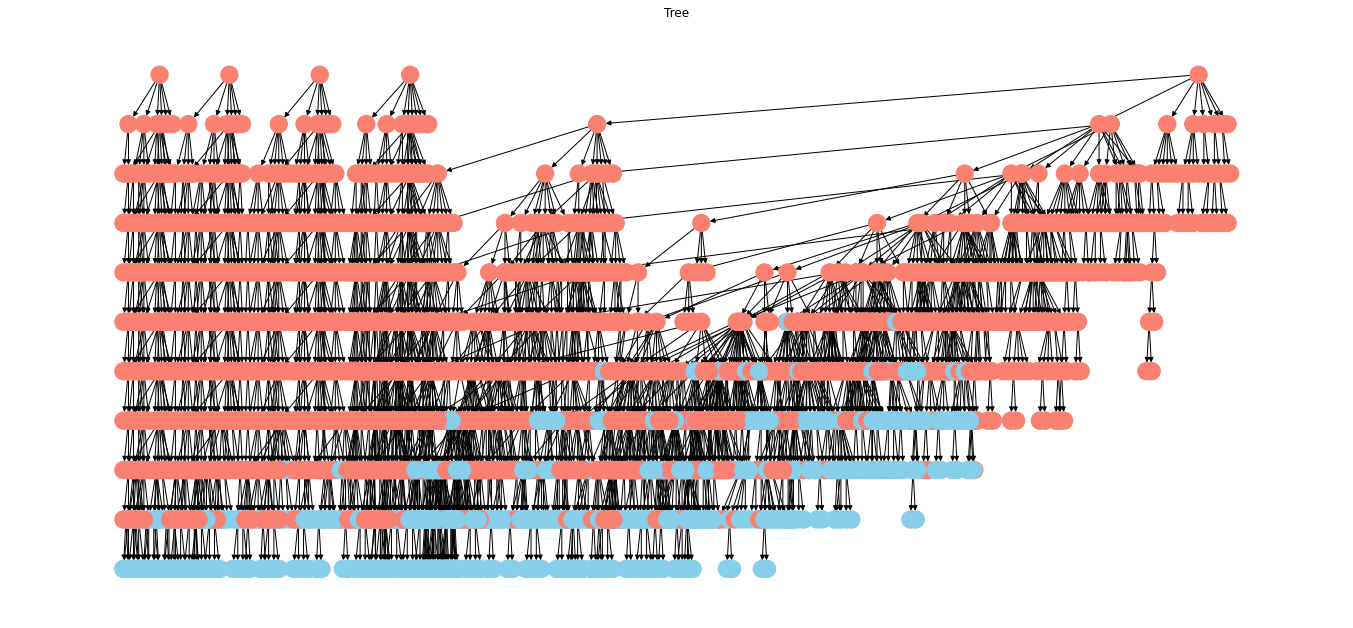

<Figure size 1728x792 with 0 Axes>

In [26]:
P_list = [
    KBadGuy2(10, [], [], []),
    KBadGuy2(20, [], [], []),
    KBadGuy2(30, [], [], []),
    KBadGuy2(25, [], [], []),
    KBadGuy2(60, [], [], []),
]

G = evolvingMPIPD(P_list, 10, 30, 40, children=2)

In [ ]:
# colors = nx.get_node_attributes(G, "color")

# for key, value in colors.items():
#     if value == "salmon":
#         colors[key] = "white"

# nx.set_node_attributes(G, colors, "color")

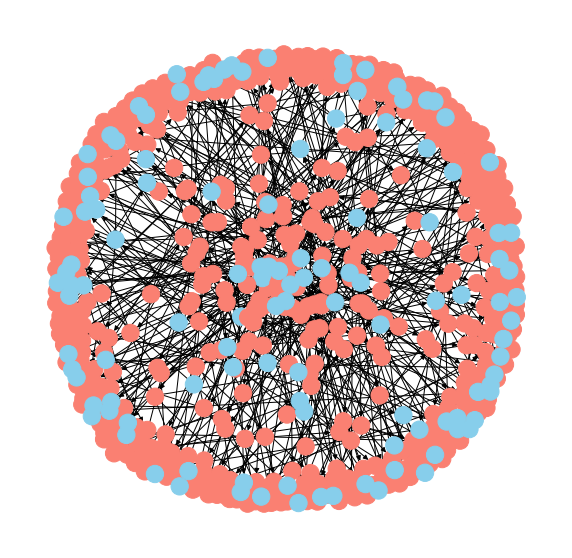

In [27]:
# fig, ax = plt.subplots(figsize=(24, 11))
pos = graphviz_layout(G, prog="dot")
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(
    G,
    #     pos,
    node_color=nx.get_node_attributes(G, "color").values(),
    with_labels=False,
    arrows=True,
)

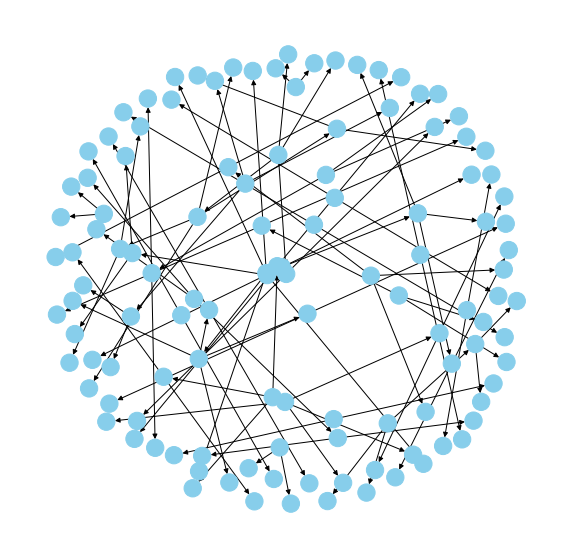

In [28]:
nodes_list = list(G.nodes(data="color"))
for i, color in nodes_list:
    if color == "salmon":
        G.remove_node(i)

# fig, ax = plt.subplots(figsize=(24,6))
# pos = graphviz_layout(G, prog="dot")
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(
    G,
#     pos,
    node_color=nx.get_node_attributes(G, "color").values(),
    with_labels=False,
    arrows=True,
)

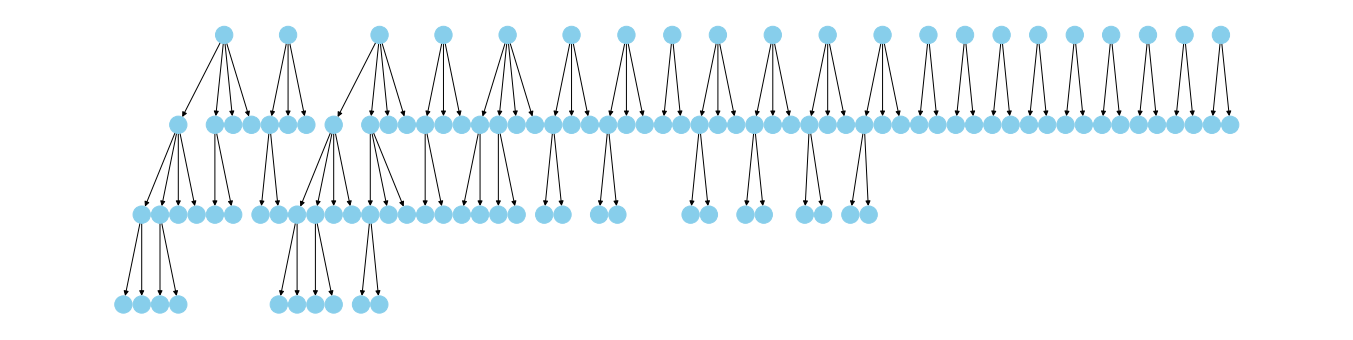

In [29]:
fig, ax = plt.subplots(figsize=(24, 6))
pos = graphviz_layout(G, prog="dot")
nx.draw(
    G,
    pos,
    node_color=nx.get_node_attributes(G, "color").values(),
    with_labels=False,
    arrows=True,
)

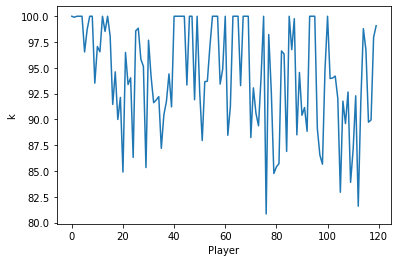

In [31]:
k_list = []
for player in P_list:
    k_list.append(player.k)

# TODO make nice plots of k and family
# TODO real time plot inside the function?
plt.figure()
plt.plot(k_list)
plt.xlabel("Player")
plt.ylabel("k")
plt.show()

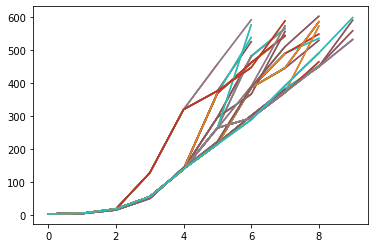

In [41]:
k_list = []
for player in P_list:
    plt.plot(player.family)
plt.show()

### Try with different players

In [42]:
class Tit4TatMP2(Player):
    """
    Player that starts with cooperate and then cooperates only if a fraction of players
    above or equal c_treshold has cooperated.
    """

    def __init__(
        self,
        family=[],
        r_history=[],
        move_history=[],
        input_history=[],
        c_threshold=0.5,
        ID=None,
    ):
        self.ID = ID
        self.family = family
        self.r_history = r_history
        self.move_history = move_history
        self.input_history = input_history
        self.c_threshold = c_threshold

    def append_reward(self, reward):
        self.r_history.append(reward)

    def append_input(self, m_inp):
        """
        multiplayer input m_inp should be an array or list with N rows for N players,
        in every row the list [1,0] or [0,1], it also works with [1] or [0].
        The number of input players can change.
        """
        self.input_history.append(m_inp)

    def move(self):
        if len(self.input_history) == 0:
            u = [1, 0]
        else:
            last_inp = np.array(self.input_history[-1])[:, 0]
            if np.sum(last_inp) / np.shape(last_inp)[0] >= self.c_threshold:
                u = [1, 0]
            else:
                u = [0, 1]
        self.move_history.append(u)
        return u


class GrimTriggerMP2(Player):
    """
    Player that cooperates until a numbers of players >= d_threshold defect in a turn,
    from now on he defects in every turn.
    Setting d_threshold=0 means that it needs only one defecting player
    to start defecting itself.
    """

    def __init__(
        self,
        family=[],
        r_history=[],
        move_history=[],
        input_history=[],
        d_threshold=0.5,
        ID=None,
    ):
        self.ID = ID
        self.family = family
        self.r_history = r_history
        self.move_history = move_history
        self.input_history = input_history
        self.d_threshold = d_threshold
        self.defected = False

    def append_reward(self, reward):
        self.r_history.append(reward)

    def append_input(self, m_inp):
        """
        multiplayer input m_inp should be an array or list with N rows for N players,
        in every row the list [1,0] or [0,1], it also works with [1] or [0].
        The number of input players can change.
        """
        self.input_history.append(m_inp)

    def move(self):
        if not self.defected and len(self.input_history) > 0:
            # check if it has been defected in the last turn
            last_inp = last_inp = np.array(self.input_history[-1])[:, 0]
            if np.sum(last_inp) / np.shape(last_inp)[0] < 1 - self.d_threshold:
                self.defected = True
        #                 print("debug DEFECTED")

        if not self.defected:
            u = [1, 0]
        else:
            u = [0, 1]
        self.move_history.append(u)
        return u
    
class LookBackPlayer2(Player):
    """
    Player that use past rewards in order to decide the next move.
    """

    def __init__(self, bias, family=[], r_history=[], move_history=[], ID=None):
        """
        bias is added to the past rewards during the move decision
        if bias is in range [-3,0] it can change the behaviour of the player
        """
        self.ID = ID
        self.family = family
        self.r_history = r_history
        self.move_history = move_history
        self.bias = bias

    def append_reward(self, reward):
        self.r_history.append(reward)

    def move(self):
        # random move if its the first move
        if len(self.r_history) == 0:
            if np.random.rand() >= 0.5:
                u = [1, 0]
            else:
                u = [0, 1]
        else:
            move_cat_history = np.array(self.move_history)
            r_cat_history = np.concatenate(
                (np.array([self.r_history]).T, np.array([self.r_history]).T), axis=1
            )
            sum_cat_r = np.sum((r_cat_history + self.bias) * move_cat_history, axis=0)

            if sum_cat_r[0] > sum_cat_r[1]:
                # cooperate
                u = [1, 0]
            elif sum_cat_r[0] < sum_cat_r[1]:
                # defect
                u = [0, 1]
            else:
                # random choice if parity
                if np.random.rand() >= 0.5:
                    u = [1, 0]
                else:
                    u = [0, 1]

        self.move_history.append(u)
        return u

In [43]:
# P_list = player list
def evolvingMPIPD2(P_list, num_epochs, GI, max_population, children=1, delta_range=10):
    """
    parameters:
        P_list (list): initial players instances.
        num_epochs (int): number of epochs performed.
        GI (int): game iterations inside a epoch.
        max_population (int): maximum number of players that can be active
            during an epoch.
    Return:
        it modifies the input P_list
        G: directed graph networkx
    """
    G = nx.DiGraph()

    id_sup = IDSupplier()
    for i, player in enumerate(P_list):
        player.ID = id_sup.new_id()
        G.add_node(player.ID, color="skyblue", player_type=type(player).__name__)

    fig, ax = plt.subplots(figsize=(24, 11))

    for epoch in range(num_epochs):
        # reset the reward history
        for player in P_list:
            player.r_history = []

        # call a game loop
        MPIPD(P_list, GI)

        def key_r(player):
            return sum(player.r_history)

        # sort the player list inplace
        P_list.sort(reverse=True, key=key_r)

        # kill the player with small rewards and keep population stable
        while len(P_list) > max_population:
            dead_player = P_list.pop()
            colors = nx.get_node_attributes(G, "color")
            colors[dead_player.ID] = "salmon"
            nx.set_node_attributes(G, colors, "color")

        # remaining players make new children
        current_P = len(P_list)

        for player in P_list[0:current_P]:

            player_type = type(player).__name__
            for i in range(children):

                if player_type == "KBadGuy2":
                    son = KBadGuy2(
                        player.k,
                        player.family + [player.ID],
                        [],
                        [],
                        ID=id_sup.new_id(),
                    )
                elif player_type == "Tit4TatMP2":
                    son = Tit4TatMP2(
                        player.family + [player.ID],
                        [],
                        [],
                        [],
                        c_threshold=player.c_threshold,
                        ID=id_sup.new_id(),
                    )

                elif player_type == "GrimTriggerMP2":
                    son = GrimTriggerMP2(
                        player.family + [player.ID],
                        [],
                        [],
                        [],
                        d_threshold=player.d_threshold,
                        ID=id_sup.new_id(),
                    )
                elif player_type == "LookBackPlayer2":
                    son = LookBackPlayer2(
                        bias=player.bias,
                        family=player.family + [player.ID],
                        r_history=[],
                        move_history=[],
                        ID=id_sup.new_id(),
                    )

                G.add_node(son.ID, color="skyblue", player_type=player_type)
                G.add_edge(player.ID, son.ID)
                P_list.append(son)

        plt.title("Tree")
        pos = graphviz_layout(G, prog="dot")
        nx.draw(
            G,
            pos,
            node_color=nx.get_node_attributes(G, "color").values(),
            with_labels=True,
            labels=nx.get_node_attributes(G, "player_type"),
            arrows=True,
        )
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.savefig(f"epoch_{epoch}.png")

    plt.clf()
    return G

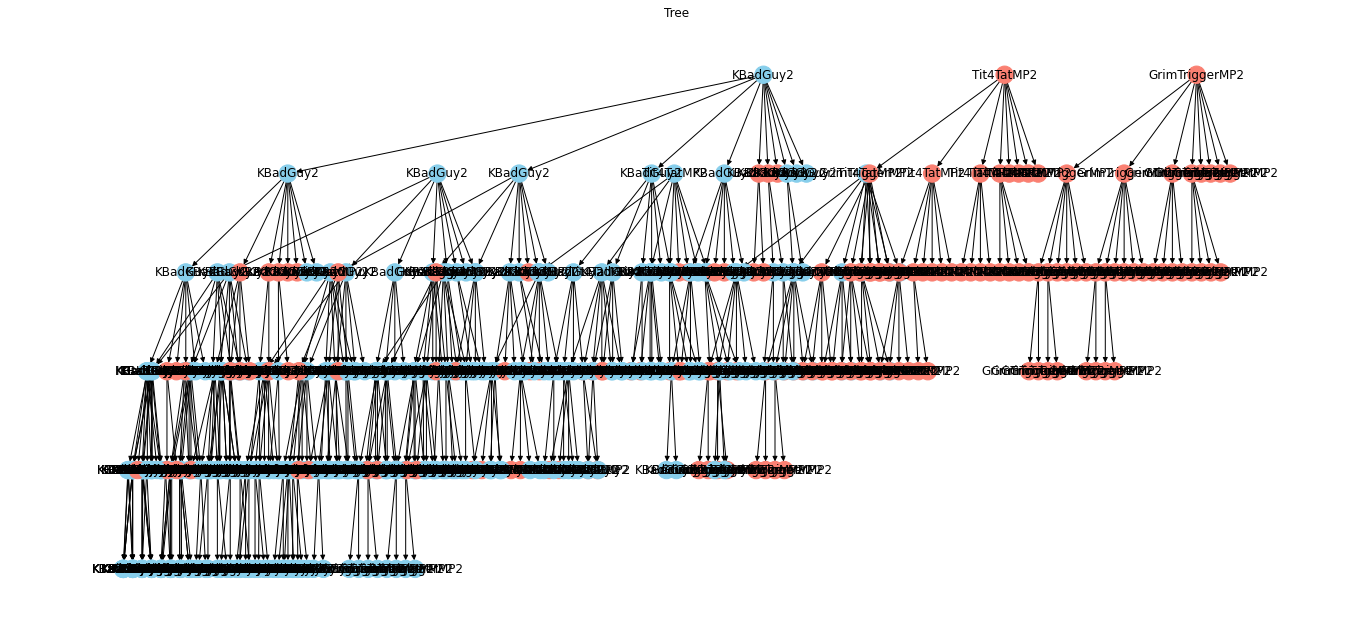

<Figure size 1728x792 with 0 Axes>

In [53]:
P_list = [
    KBadGuy2(10, [], [], []),
    Tit4TatMP2([], [], [], [], c_threshold=0.5),
    GrimTriggerMP2([], [], [], [], 0),
    #     LookBackPlayer2(0, [],[],[]),
]

G = evolvingMPIPD2(P_list, 5, 30, 40, children=2)

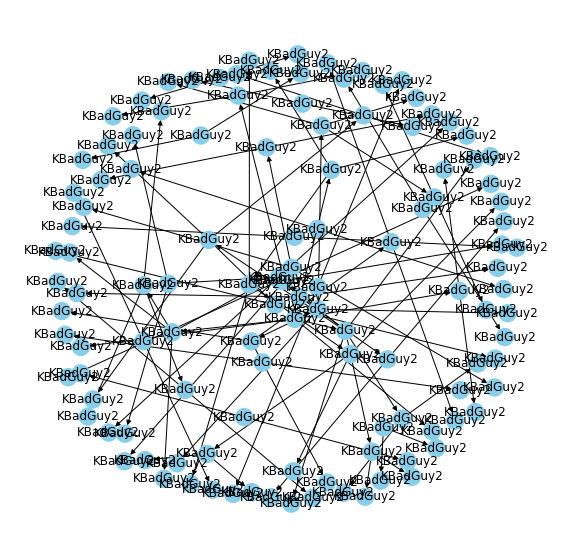

In [54]:
nodes_list = list(G.nodes(data="color"))
for i, color in nodes_list:
    if color == "salmon":
        G.remove_node(i)

fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(
    G,
    node_color=nx.get_node_attributes(G, "color").values(),
    with_labels=True,
    labels=nx.get_node_attributes(G, "player_type"),
    arrows=True,
)

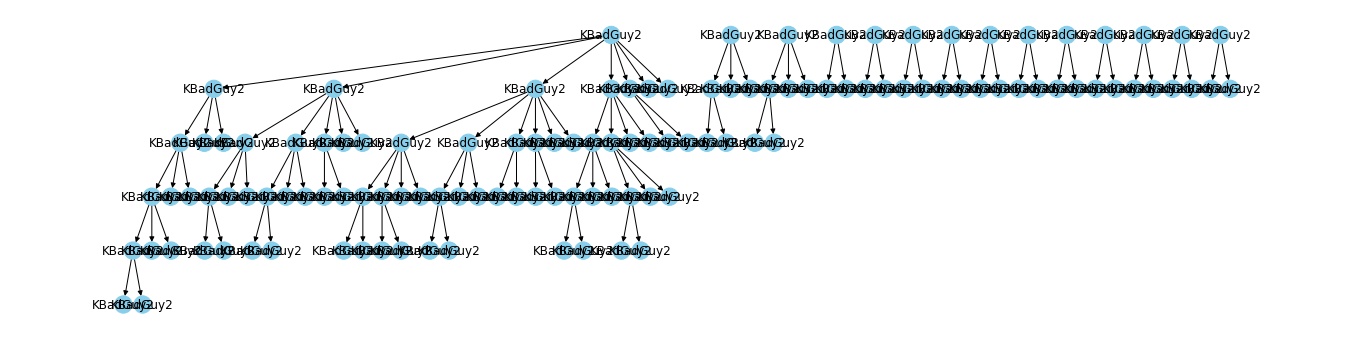

In [55]:
fig, ax = plt.subplots(figsize=(24, 6))
pos = graphviz_layout(G, prog="dot")
nx.draw(
    G,
    pos,
    node_color=nx.get_node_attributes(G, "color").values(),
    with_labels=True,
    labels=nx.get_node_attributes(G, "player_type"),
    arrows=True,
)

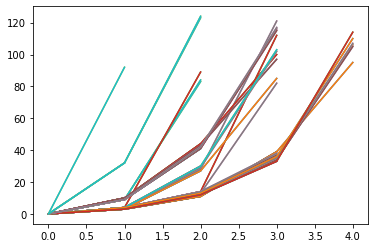

In [65]:
k_list = []
for player in P_list:
    plt.plot(player.family)
plt.show()